# Analysis of Audience motion power spectra, Musiclab Copenhagen


Generation of plots for Audience Motion paper

In [1]:
import sys
import os
import time

import datetime as dt
import math
import numpy as np 
import scipy as sp
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter,filtfilt
from scipy import interpolate
from scipy.interpolate import interp1d
import matplotlib.cm as cm
import pingouin as pg

import matplotlib.gridspec as gridspec

In [2]:
# import functions from definition files in the same folder as this jupiter notebook
%load_ext autoreload
%autoreload 1
%aimport am

In [3]:
%reload_ext autoreload

In [4]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

# Data preparation 
Aligning cellphone accelerometer measurements collected via MusicLab App and AX3 measurements from audience participant was performed in a different repository. This process depended on the detection of taps by participants on their devices to the synchronisation cues played before each half of the concert. See Notebook below for a summary of that work to align accelerometer measurements: 
https://github.com/finn42/MusicLabCopenhegan_MotionAlignment/blob/main/Alignment_Describe.ipynb

These aligned accelerometer measurments were released publically as part of the MusicLab Copenhagen repository (https://osf.io/v9wa4/). This analysis uses the fullowing published datasets from this study:

  1. Aligned accelerometer measurements from each audience member: https://osf.io/9qeg6/
  2. Participants' survey responses: https://osf.io/89s5w/ 
  3. Anonimised seating information for in hall participants: https://osf.io/8t4rz/ ./Participants/Near_Participants_Hall.csv (https://osf.io/c5zgf)
  4. Concert event timing information:  https://osf.io/8t4rz/ ./Timing/Events_Main.csv

In [5]:
general_loc = '../'
public_Part = general_loc + 'Public_data/Participants/'
public_time = general_loc + 'Public_data/Timing/'

In [6]:
internal_Part = general_loc + 'Participants_internal/'

In [7]:
# set the sampling period for the concert in UTC 
Start_time = pd.to_datetime('2021-10-26 17:30:00+0000').replace(tzinfo=None)
Synch_time = pd.to_datetime('2021-10-26 17:48:06+0000').replace(tzinfo=None)
Mid_time = pd.to_datetime('2021-10-26 19:00:00+0000').replace(tzinfo=None)
End_time = pd.to_datetime('2021-10-26 20:30:00+0000').replace(tzinfo=None)


In [8]:
# concert times 10 Hz
ts_ct = np.arange(-1086,9715, 0.1)*1000 
dt_ct = Synch_time + pd.to_timedelta(ts_ct,unit='ms')
sF = 10

In [9]:
concert_times = pd.read_csv(public_time +'Events_Main_Segments.csv',sep=",") #SV alignment for beeps
# concert_times = pd.read_csv(public_time +'Events_Main_extra_Tags.csv',sep=",") #SV alignment for beeps
concert_times['Datetime']=(pd.to_datetime(concert_times['Datetime'])) # concert time stamps, confirm format

concert_times['sequence'] = concert_times.index
Main_concert_times = concert_times.set_index('Datetime')

In [10]:
evord = ['Beethoven', 'Schnittke', 'Bach', 'Folk',  'Survey','Speech', 'Clapping', ]
Main_concert_times['Sections']=''
for ev in evord:
    Main_concert_times.loc[Main_concert_times['Event'].str.startswith(ev[:4]),'Sections'] = ev

Main_concert_times.iloc[:5,:]

Time_s  Time_ms            Event Event_Type  Time_Stream  \
Datetime                                                                        
2021-10-26 17:36:35 -691.24  -691240  Clapping for MC   Applause       946.00   
2021-10-26 17:36:53 -673.12  -673120           Speech     Speech       964.12   
2021-10-26 17:38:50 -556.04  -556040  Clapping for MC   Applause      1081.20   
2021-10-26 17:38:59 -547.16  -547160       Speech MC1     Speech      1090.08   
2021-10-26 17:45:16 -169.64  -169640  Clapping for MC   Applause      1467.60   

                     Event_Duration Shorter_tag  sequence  Sections  
Datetime                                                             
2021-10-26 17:36:35           18.12     Claps 0         0  Clapping  
2021-10-26 17:36:53          117.08    Speech 1         1    Speech  
2021-10-26 17:38:50            5.88     Claps 1         2  Clapping  
2021-10-26 17:38:59          377.52    Speech 2         3    Speech  
2021-10-26 17:45:16            1.05   Claps 1.1         4  Clapping

In [11]:
partDets = pd.read_csv(public_Part + 'Audience_Mapping_Public.csv')#,index_col = 0,header_col = 0)
part_det_columns = ['Participant_Code','Attendance', 'Motion_Quality', 'Seat_Zone','Watch_Alone']
# need only in person participants with aligned motion traces
partDets = partDets.loc[partDets['Attendance'].isin(['A','B']),part_det_columns] # in person hall participant
alignedParts = partDets.loc[partDets['Motion_Quality'].isin(['Q','R']),:].reset_index(drop = True) # with aligned motion measurements
aligned_Part_Codes = list(alignedParts.Participant_Code.values)
alignedParts.iloc[:5,:]

Participant_Code Attendance Motion_Quality  Seat_Zone  Watch_Alone
0           ADQ001          A              Q        6.0          0.0
1           ADQ002          A              Q        3.0          0.0
2           ADQ003          A              Q        2.0          0.0
3           ADQ004          A              Q        4.0          1.0
4           ADQ005          A              Q        4.0          0.0

Retrieve audience motion time series from previous extraction

In [15]:
aud_df = pd.read_csv('./data/essential/Audience_10Hz_sampled.csv',index_col=0)
aud_df.index = (ts_ct/1000).round(1)
ori_aud_df = aud_df.copy()

In [16]:
Main_concert_times.query('Event=="Interval"')

Time_s  Time_ms     Event Event_Type  Time_Stream  \
Datetime                                                                 
2021-10-26 18:52:48  3602.2  3602200  Interval   Interval      5239.44   

                     Event_Duration Shorter_tag  sequence Sections  
Datetime                                                            
2021-10-26 18:52:48         1278.72       Pause        24

In [17]:

ETypes = ['Music','Survey','Speech','Applause']
minDur = 60 # s
MTs = Main_concert_times.query('Event_Type in @ETypes and Event_Duration > @minDur')


# Power Spectrum analysis

In [18]:
def get_spectrogram(datain,F,W,J,scale='log'):
    '''Makes a spectrogram of the given data.
    #
    df: dataframe with data
    F: sampling frequency
    W: Window size
    J: Separation between windows
    #
    output: if input is Series output is a signle DF with spectrogram
            if intput is DF the output is dictionary with one spectrogram per column of the input dataframe
    '''
    K = range(0,len(datain)-W,J) # starting point for the windows
    K0 = [int(x+W/2) for x in K] # placing them in the middle point timestamp
    new_index = [datain.index[x] for x in K0] # extracting those timestamps
    col_freqs = [x*F/W for x in range(int(W/2)+1) ] # values of resolved freqs
    #   print(len(new_index),len(col_freqs))
    han = np.hanning(W)
    #dic = {'window_size':W,'sampling_frequency':F}
    #
    dic = {}
    for col in datain.columns:
        fourier = np.zeros((len(new_index),len(col_freqs)))
        temp = np.zeros((1,int(W/2)+1))
        j = 0
        D = datain[col]
#         D = D.diff() # discrete derivative
        D = D.dropna() # discarding nans and concatenating
        if len(D)==0:
            continue
        #   
        K0 = range(0,len(D)-W,J) # starting point for the windows
        for T0 in K0:
            data0 = D.iloc[T0:T0+W]*han
            if scale=='log':
                temp = 10*np.log10(2*abs(np.fft.fft(data0,axis=0)))
            elif scale=='abs':
                temp = abs(np.fft.fft(data0,axis=0))
            fourier[j,:] = temp[:int(W/2)+1]
            j = 1 + j
            #
        res = pd.DataFrame(fourier,index=new_index,columns=col_freqs)
#         res1 = res / (res.columns) # multiplicative adjustment for discrete derivative
        dic[col] = res#1      
        #print('Ready with ',col)
    output = dic
    #
    return output
#
def get_meanpowerspectrum(datain,F,W,J,scale='log'):
    # Obtained average spectrogram using the previous function
    spectrogram = get_spectrogram(datain,F,W,J,scale)
    dic = {}
    for key in spectrogram:
        dic[key] = spectrogram[key].mean(axis=0)
    output = pd.DataFrame(dic,index=dic[key].index)
    return output
#
#

In [19]:
sF = 10
FrameSize = 2**9
HopSize = 100

ETypes = ['Music','Survey','Speech','Applause']
minDur = 60 # s
MTs = Main_concert_times.query('Event_Type in @ETypes and Event_Duration > @minDur')

Specs = {}
for i,r in MTs.iterrows():
    sigs=ori_aud_df.loc[r['Time_s']:r['Time_s']+r['Event_Duration'],:].copy()
    Specs[r['Shorter_tag']] = get_meanpowerspectrum(sigs,sF,FrameSize,HopSize,scale='abs')
    

In [20]:
Specs.keys()

dict_keys(['Speech 1', 'Speech 2', 'Speech 3', 'Beeth. 1', 'Beeth. 2', 'Beeth. 3', 'Beeth. 4', 'Survey 1', 'Schnit. 1', 'Schnit. 2', 'Schnit. 3', 'Claps 5', 'Survey 2', 'Speech 7', 'Bach', 'Survey 3', 'Folk 1', 'Folk 2', 'Folk 3', 'Folk 4', 'Folk 5', 'Folk 6', 'Claps 14', 'Survey 4'])

Combine power spectra per participant per meta event category. Note this needs to handle partial missing data from some participants

In [21]:
ev_tags = ['Music','Survey','Speech','Applause']
df_means = pd.DataFrame(index = ev_tags,columns = ori_aud_df.columns)
for ev_tag in ev_tags:
    MTs = Main_concert_times.loc[Main_concert_times['Event_Type']==ev_tag,:]
    sigs = []
    for i,r in MTs.iterrows():
         sigs.append(ori_aud_df.loc[r['Time_s']:r['Time_s']+r['Event_Duration'],:].copy())
    fullset = pd.concat(sigs,axis=0)
    df_means.loc[ev_tag,:] = fullset.mean()
df_means

ADQ001    ADQ002    ADQ003    ADQ004    ADQ005    ADQ006  \
Music      0.07526  0.118797  0.102419  0.132902  0.084625  0.108337   
Survey    0.209239  0.276741  0.138638  0.390651  0.154346   0.20982   
Speech    0.237084  0.198759  0.296846   0.34362  0.140576  0.238434   
Applause  0.938128  0.802796   1.06222  1.152516  0.567129  1.359547   

            ADQ007    ADQ008    ADQ009    ADQ010  ...    BEQ113    BEQ114  \
Music     0.089495  0.091163  0.077331  0.132353  ...  0.090992  0.259847   
Survey    0.193861  0.116464  0.160078  0.598902  ...   2.63744  0.300593   
Speech    0.141595  0.172588  0.139657  0.384551  ...  0.269565   0.49058   
Applause  1.303809  1.125798  0.856135  1.224338  ...  0.235498  0.411525   

            BEQ115    BEQ116    BEQ117    BEQ118    BEQ119    BnQ131  \
Music     0.157987  0.173808  0.323958  0.180356  0.041645  0.089809   
Survey         NaN   0.21808  0.455517       NaN       NaN  0.257953   
Speech    0.128703   0.40729  1.143721    0.3095   0.02373  0.164658   
Applause  0.168537  0.229127  0.441142  0.372743  0.443953  0.208247   

            BnQ132    BnQ133  
Music     0.106949  0.098911  
Survey    0.263718  0.225292  
Speech     0.27555  0.356039  
Applause  0.400149  0.301939  

[4 rows x 115 columns]

In [22]:
SuperSpecs = {}
for ev in ev_tags:
    sub_evs = Main_concert_times.query('Event_Type==@ev and Event_Duration > @minDur')
    Parts = list(df_means.columns[df_means.loc[ev].notna()])
    df_parts = pd.DataFrame(columns = Parts)
    for partID in Parts:
        df=pd.DataFrame()
        for s in sub_evs['Shorter_tag']:
            if partID in Specs[s].columns:
                df[s] = Specs[s].loc[:,partID].copy()
        df_parts[partID] = df.mean(axis=1)
    SuperSpecs[ev]=df_parts.copy()

In [23]:
D_evs = []
for ev in SuperSpecs.keys(): # just in hall
    df = SuperSpecs[ev].loc[:,SuperSpecs[ev].columns.str.startswith('A')].T.melt(var_name='Frequency', value_name='Power')
    df['Event'] = ev
    D_evs.append(df)
D = pd.concat(D_evs,axis=0)
D.replace([np.inf, -np.inf], np.nan, inplace=True)
D = D.dropna()

D_evs = []
for ev in Specs.keys(): # just in hall
    df = Specs[ev].loc[:,Specs[ev].columns.str.startswith('A')].T.melt(var_name='Frequency', value_name='Power')
    df['Event'] = ev
    D_evs.append(df)
Ds = pd.concat(D_evs,axis=0)
Ds.replace([np.inf, -np.inf], np.nan, inplace=True)
Ds = Ds.dropna()

In [24]:
G_evs = []
for ev in SuperSpecs.keys(): # just remote
    df = SuperSpecs[ev].loc[:,SuperSpecs[ev].columns.str.startswith('B')].T.melt(var_name='Frequency', value_name='Power')
    df['Event'] = ev
    G_evs.append(df)
G = pd.concat(G_evs,axis=0)
G.replace([np.inf, -np.inf], np.nan, inplace=True)
G = G.dropna()

G_evs = []
for ev in Specs.keys(): # just remote
    df = Specs[ev].loc[:,Specs[ev].columns.str.startswith('B')].T.melt(var_name='Frequency', value_name='Power')
    df['Event'] = ev
    G_evs.append(df)
Gs = pd.concat(G_evs,axis=0)
Gs.replace([np.inf, -np.inf], np.nan, inplace=True)
Gs = Gs.dropna()

### Resting Heart Rate Distribution model

We also want to have the estimated distribution of resting heart rates for this population, given the ages represented. Note the true ages are used, according to survey responses from in hall participants, but the distribution is oversampled * 4 to stablise the quantile ranges used in the plots. The heart rate distributions are generated randomly from heart rate distributions reported by age with a single split linear model on age from mean and standard deviations. Parameters from https://www.nature.com/articles/s41746-019-0134-9

In [25]:
Quest_df = pd.read_csv(public_Part + 'Surveys_Prepared_Data_Public.csv',sep=',', encoding='latin-1')
ages = Quest_df.loc[Quest_df['ParticipantCode'].str.startswith('A'),'age']

In [26]:
import random
random.seed(time.time())

def modelHR(age):
# https://www.nature.com/articles/s41746-019-0134-9#Sec2
# In healthy individuals, average resting HR-PPG decreased from 81.6 ± 14.0 in those aged 18–20 to 74.2 ± 12.7 in those aged 71–80 (p < 0.0005) (Table 2 and Fig. 1a).
# https://www.nature.com/articles/s41746-019-0134-9/figures/1
# split elbow model of average heart rates, bend at 55 for slop and spread
#     sigma = 14 - (14-12.7)*(age-19)/(80 - 19)
#     mu = 81.6 - (81.6-74.2)*(age-19)/(80 - 19)
    if age<55:
        sigma = 14
        mu = 81.6 - (81.6-73)*(age-19)/(55 - 19)
    else:
        sigma = 14 - (14-12.7)*(age-55)/(80 - 55)
        mu = 73 - (73-74.2)*(age-55)/(80 - 55)
    return random.gauss(mu,sigma)

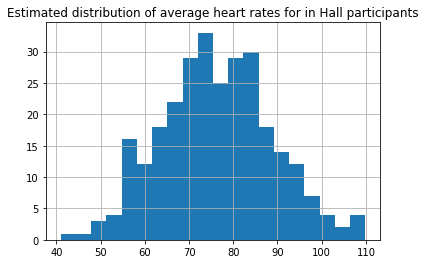

Average modeled heart rates 76.20  (12.68), [.1,.25,.5,.75,.9] [58.56,67.47,75.81,84.37,92.70]


In [43]:
hrs = []
for a in ages: # over sample to smooth out the random 
    hrs.append(modelHR(a))
    hrs.append(modelHR(a))
    hrs.append(modelHR(a))
    hrs.append(modelHR(a))
hrs = pd.Series(hrs)
hrs.hist(bins=20)
plt.title('Estimated distribution of average heart rates for in Hall participants')
plt.savefig('./supplemental_plots/Model_HR.png',dpi=196)
plt.show()
quants = [hrs.quantile(0.1),hrs.quantile(0.25),hrs.quantile(0.5),hrs.quantile(0.75),hrs.quantile(0.9)]
print('Average modeled heart rates {:.2f}  ({:.2f}), [.1,.25,.5,.75,.9] [{:.2f},{:.2f},{:.2f},{:.2f},{:.2f}]'.format(hrs.mean(),hrs.std(),quants[0],quants[1],quants[2],quants[3],quants[4]))

The exact values shift around with each random iteration. The values used in the published graph are representative of the trend across samplings, even if not exactly what gets rendered every time.

## Audio power spectrum

In [30]:
sF = 10
FrameSize = 2**9
HopSize = 100

Fs = 48000 #48 kHz
win_len_sec = 0.1
audio_loc = '../Stimuli/Events/'

ETypes = ['Music','Survey','Speech','Applause']
minDur = 60 # s
MTs = Main_concert_times.query('Event_Type in @ETypes and Event_Duration > @minDur')

AudioSpecs = {}
for i,r in MTs.iterrows():
    Peice_tag = '_'.join(r['Shorter_tag'].split(' ')).replace("._", "_")
    # data extracted in 4_Concert_Audio_Power_Spectrum
    seg = pd.read_csv('./data/Audio_RMS/' + r['Event_Type'] + '_' + Peice_tag + '_RMS.csv',index_col=0)
    AudioSpecs[r['Shorter_tag']] = get_meanpowerspectrum(seg,sF,FrameSize,HopSize,scale='abs')

In [31]:
ev_tags = ['Music','Survey','Speech','Applause']
SuperAudioSpecs = {}
for ev in ev_tags:
    sub_evs = Main_concert_times.query('Event_Type == @ev and Event_Duration > @minDur')
    df=pd.DataFrame()
    for s in sub_evs['Shorter_tag']:
        df[s] = AudioSpecs[s].copy()
    SuperAudioSpecs[ev]=pd.DataFrame(df.mean(axis=1),columns=[ev])

In [32]:
DA_evs = []
for ev in SuperAudioSpecs.keys(): # just in hall
    df = SuperAudioSpecs[ev].T.melt(var_name='Frequency', value_name='Power')
    df['Event'] = ev
    DA_evs.append(df)
DA = pd.concat(DA_evs,axis=0)
DA.replace([np.inf, -np.inf], np.nan, inplace=True)
DA = DA.dropna()

DA_evs = []
for ev in AudioSpecs.keys(): # just in hall
    df = AudioSpecs[ev].T.melt(var_name='Frequency', value_name='Power')
    df['Event'] = ev
    DA_evs.append(df)
DAs = pd.concat(DA_evs,axis=0)
DAs.replace([np.inf, -np.inf], np.nan, inplace=True)
DAs = DAs.dropna()

In [33]:
ev = 'Applause'
a = DA.query('Event==@ev').loc[:,['Frequency','Power']].groupby(by=['Frequency']).mean()
print(60*a.loc[2:].idxmax())
1/a.loc[2:].idxmax()

Power    176.953125
dtype: float64


Power    0.339073
dtype: float64

In [34]:
ev = 'Applause'
a = D.query('Event==@ev').loc[:,['Frequency','Power']].groupby(by=['Frequency']).mean()
print(60*a.loc[2:].idxmax())
1/a.loc[2:].idxmax()

Power    176.953125
dtype: float64


Power    0.339073
dtype: float64

In the applause, 2.8 Hzcorresponds to the clapping IBI (0.36 s) at the start of the synchronised clapping for the final interval. 2.97 is around 0.33 s, is the median of clapping 14. 

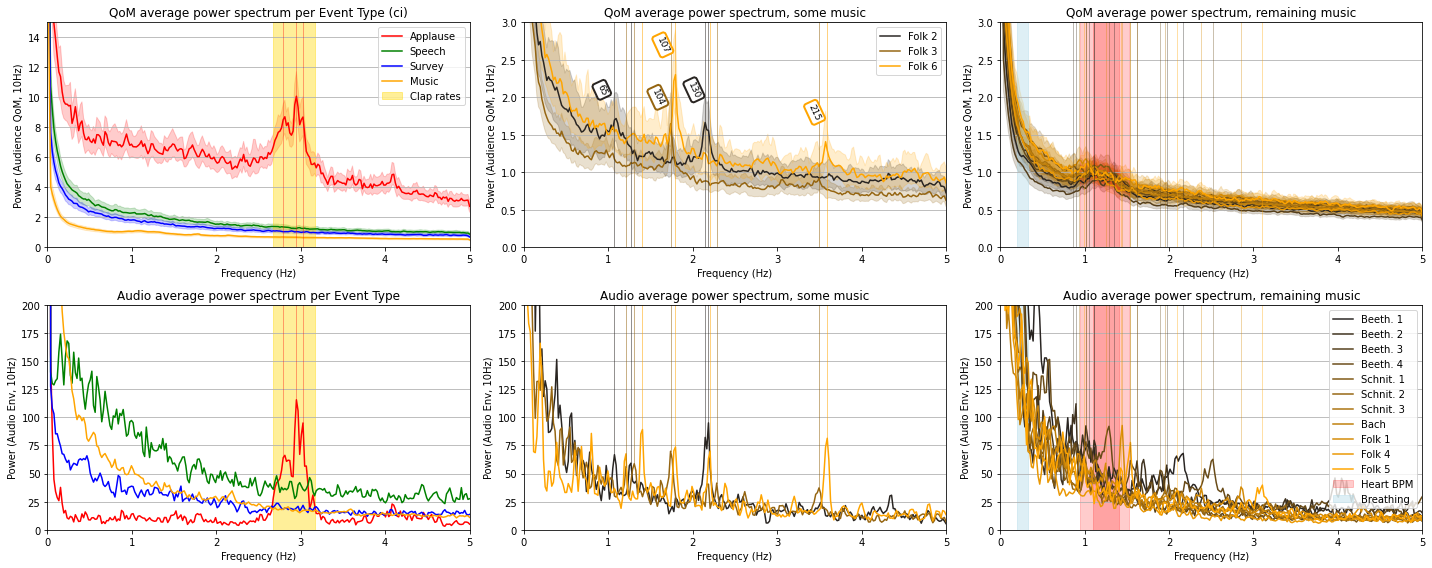

In [35]:
# General aspect of figure
fig, axes = plt.subplots(2,3,figsize=(20, 8))# ,sharex=True
errorbarType ='ci' # 'ci' # 'se'
minf = 0.7

#
ax=axes[0,0]
ev_tags =  ['Applause','Speech','Survey','Music']
Event_palette={'Music':'orange','Applause':'red','Speech':'green','Survey':'blue'}
sns.lineplot(data=D, x='Frequency',y='Power',hue='Event',hue_order = ['Applause','Speech','Survey','Music'],errorbar=errorbarType,err_style='band', palette=Event_palette,ax=ax)
ax.set(xlim=(0,5), ylim=(0, 15))
ax.axvspan(2.66666667, 3.16666667,color='gold',alpha=0.4,label='Clap rates') #,label='Clapping rates'
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (Audience QoM, 10Hz)')
ax.set_title('QoM average power spectrum per Event Type (' + errorbarType + ')')
ax.legend(loc='upper right')
ax.grid(axis='y')

ax=axes[1,0]
sns.lineplot(data=DA, x='Frequency',y='Power',hue='Event',hue_order = ['Applause','Speech','Survey','Music'],errorbar=errorbarType,err_style='band',legend=False, palette=Event_palette,ax=ax)
ax.set(xlim=(0,5), ylim=(0,200))
ax.axvspan(2.66666667, 3.16666667,color='gold',alpha=0.4)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (Audio Env, 10Hz)')
ax.set_title('Audio average power spectrum per Event Type')
ax.grid(axis='y')

for c in range(len(ev_tags[:1])):
    ev =ev_tags[c]
    a = DA.query('Event==@ev').loc[:,['Frequency','Power']].groupby(by=['Frequency']).mean()
    b = a.loc[minf:]-a.loc[minf:].rolling(15,center=True).mean()
    thresh = b.quantile(0.97).values[0]
    b[b<thresh] = 0
    peaks = np.sign(b.diff()).diff().shift(-1).query('Power == -2.0')
    peaks['Power'] = a.loc[peaks.index]
    if b.loc[peaks.index].max().values[0]>15: # previous b
        for i,peak in peaks.iterrows():
            axes[0,0].plot([i,i],[0,15],linewidth = 1,color=Event_palette[ev],alpha = 0.35)
            axes[1,0].plot([i,i],[peak['Power'],200],linewidth = 1,color=Event_palette[ev],alpha = 0.35) 

ax=axes[0,1]
# sub_evs = ['Folk 1','Folk 2', 'Folk 3', 'Folk 4', 'Folk 5','Folk 6' ]
sub_evs = pd.Series(['Folk 2', 'Folk 3','Folk 6'])
Ds_sub = Ds.query('Event in @sub_evs')
sns.lineplot(data=Ds_sub, x='Frequency',y='Power',hue='Event',hue_order = sub_evs,palette="dark:orange", errorbar=errorbarType,err_style='band',ax=ax) #
ax.set(xlim=(0,5),ylim=(0, 3))
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (Audience QoM, 10Hz)')
ax.set_title('QoM average power spectrum, some music')
ax.legend(loc='upper right')
ax.grid(axis='y')

ax=axes[1,1]
DAs_sub = DAs.query('Event in @sub_evs')
sns.lineplot(data=DAs_sub, x='Frequency',y='Power',hue='Event',hue_order = sub_evs,palette="dark:orange", errorbar=errorbarType,err_style='band',legend=False,ax=ax) #
ax.set(xlim=(0,5),ylim=(0, 200))
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (Audio Env, 10Hz)')
ax.set_title('Audio average power spectrum, some music')
ax.grid(axis='y')

cp = sns.color_palette("dark:orange", len(sub_evs))
for c in range(len(sub_evs)):
    ev =sub_evs[c]
    a = DAs.query('Event==@ev').loc[:,['Frequency','Power']].groupby(by=['Frequency']).mean()
    b = a.loc[minf:]-a.loc[minf:].rolling(15,center=True).mean()
    thresh = b.quantile(0.97).values[0]
    b[b<thresh] = 0
    peaks = np.sign(b.diff()).diff().shift(-1).query('Power == -2.0')
    peaks['Power'] = a.loc[peaks.index]
    if b.loc[peaks.index].max().values[0]>15:  # previous b
        for i,peak in peaks.iterrows():
            axes[0,1].plot([i,i],[0,4],linewidth = 1,color=cp[c],alpha = 0.5)
            axes[1,1].plot([i,i],[peak['Power'],200],linewidth = 1,color=cp[c],alpha = 0.5) 
#annotations for tempo in BPM (rounded)
tempo_tags = {'65':[1.074219,1.7,'Folk 2'],
'130':[2.165,1.7,'Folk 2'],
'104':[1.738281,1.6,'Folk 3'],
'107':[1.796875,2.3,'Folk 6'],
'215':[3.593750 ,1.4,'Folk 6']}
tempo_tags = pd.DataFrame(data = tempo_tags).T
tempo_tags.rename(columns ={0:'Frequency',1:'Power',2:'Piece'},inplace=True)
ax = axes[0,1]
for tempo,r in tempo_tags.iterrows(): 
    c = sub_evs[sub_evs==r['Piece']].index[0]
    t = ax.text(r['Frequency']-0.15, r['Power']+0.4, tempo,
            ha="center", va="center", rotation=-65, size=9,
            bbox=dict(boxstyle="round,pad=0.3",
                      fc='white', ec=cp[c], lw=2))
            
ax=axes[0,2]
sub_evs = ['Beeth. 1', 'Beeth. 2', 'Beeth. 3', 'Beeth. 4', 'Schnit. 1', 'Schnit. 2', 'Schnit. 3', 'Bach','Folk 1','Folk 4', 'Folk 5']
# sub_evs = ['Beeth. 1', 'Beeth. 2', 'Beeth. 3', 'Beeth. 4', 'Schnit. 1', 'Schnit. 2', 'Schnit. 3', 'Bach',]
Ds_sub = Ds.query('Event in @sub_evs')
sns.lineplot(data=Ds_sub, x='Frequency',y='Power',hue='Event',errorbar=errorbarType,err_style='band', palette="dark:orange",legend=False,ax=ax)
ax.axvspan(quants[1]/60, quants[3]/60 ,color='red',alpha=0.2,label='Heart BPM') # estimated quantile range 
ax.axvspan(quants[0]/60, quants[4]/60 ,color='red',alpha=0.2)
ax.axvspan(0.2, 0.33,color='lightblue',alpha=0.4,label='Breathing')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (Audience QoM, 10Hz)')
ax.set_title('QoM average power spectrum, remaining music')
# ax.set(xlim=(0,5),ylim=(0.3, 2))
ax.set(xlim=(0,5),ylim=(0, 3))
ax.grid(axis='y')


ax=axes[1,2]
DAs_sub = DAs.query('Event in @sub_evs')
sns.lineplot(data=DAs_sub, x='Frequency',y='Power',hue='Event',errorbar=errorbarType,err_style='band', palette="dark:orange",ax=ax)
ax.axvspan(quants[1]/60, quants[3]/60 ,color='red',alpha=0.2,label='Heart BPM') # estimated quantile range 
ax.axvspan(quants[0]/60, quants[4]/60 ,color='red',alpha=0.2)
ax.axvspan(0.2, 0.33,color='lightblue',alpha=0.4,label='Breathing')
ax.set(xlim=(0,5),ylim=(0, 200))
ax.grid(axis='y')
ax.legend(loc='upper right')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (Audio Env, 10Hz)')
ax.set_title('Audio average power spectrum, remaining music')
cp = sns.color_palette("dark:orange", len(sub_evs))
for c in range(len(sub_evs)):
    ev =sub_evs[c]
    a = DAs.query('Event==@ev').loc[:,['Frequency','Power']].groupby(by=['Frequency']).mean()
    b = a.loc[minf:]-a.loc[minf:].rolling(15,center=True).mean()
    thresh = b.quantile(0.97).values[0]
    b[b<thresh] = 0
    peaks = np.sign(b.diff()).diff().shift(-1).query('Power == -2.0')
    peaks['Power'] = a.loc[peaks.index]
    if b.loc[peaks.index].max().values[0]>15: # previous b
        for i,peak in peaks.iterrows():
            axes[0,2].plot([i,i],[0,4],linewidth = 1,color=cp[c],alpha = 0.35)
            axes[1,2].plot([i,i],[peak['Power'],200],linewidth = 1,color=cp[c],alpha = 0.35) 

plt.tight_layout()
plt.savefig('./plots/QoMAudio_spectrum_wide.png', bbox_inches = 'tight',dpi = 196)#
plt.show()

Frequency plot of remote participants

['Beeth. 1' 'Beeth. 2' 'Beeth. 3' 'Beeth. 4']
['Schnit. 1' 'Schnit. 2' 'Schnit. 3' 'Bach']
['Folk 1' 'Folk 2' 'Folk 3' 'Folk 4' 'Folk 5' 'Folk 6']


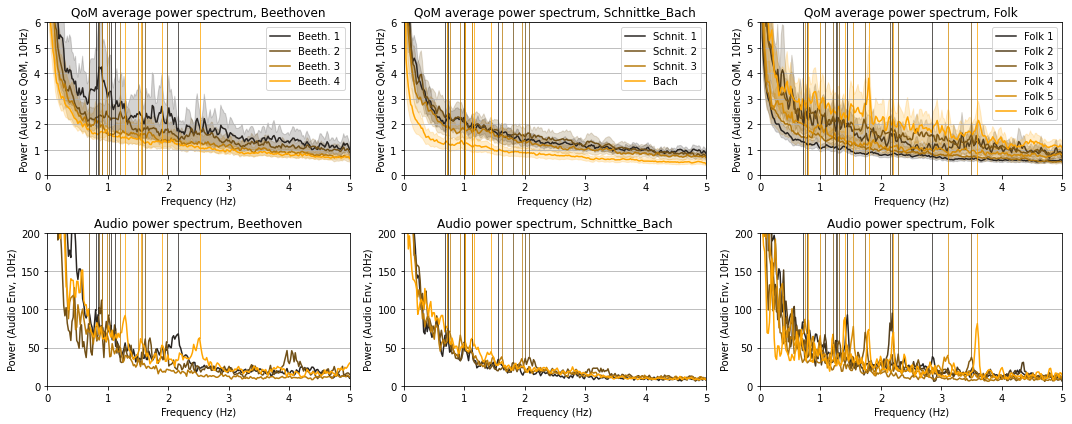

In [36]:
# General aspect of figure
fig, axes = plt.subplots(2,3,figsize=(15, 6))# ,sharex=True
errorbarType ='se' # 'ci' # 'se'
#
qom_ylim = 6
evs = ['Beethoven','Schnittke_Bach','Folk']
for i in range(len(evs)):
    ev = evs[i]
    ax=axes[0,i]
    sub_evs = MTs.query('Sections in @ev.split("_")')['Shorter_tag'].values
    print(sub_evs)
    Ds_sub = Gs.query('Event in @sub_evs').copy()
    sns.lineplot(data=Ds_sub, x='Frequency',y='Power',hue='Event',hue_order = sub_evs,palette="dark:orange", errorbar=errorbarType,err_style='band',ax=ax) #
    ax.set(xlim=(0,5),ylim=(0, qom_ylim))
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power (Audience QoM, 10Hz)')
    ax.set_title('QoM average power spectrum, '+ ev)
    ax.legend(loc='upper right')
    ax.grid(axis='y')

    ax=axes[1,i]
    DAs_sub = DAs.query('Event in @sub_evs')
    sns.lineplot(data=DAs_sub, x='Frequency',y='Power',hue='Event',hue_order = sub_evs,palette="dark:orange", errorbar=errorbarType,err_style='band',legend=False,ax=ax) #
    ax.set(xlim=(0,5),ylim=(0, 200))
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power (Audio Env, 10Hz)')
    ax.set_title('Audio power spectrum, '+ ev)
    ax.grid(axis='y')

    cp = sns.color_palette("dark:orange", len(sub_evs))
    minf = 0.5
    for c in range(len(sub_evs)):
        ev =sub_evs[c]
        a = DAs.query('Event==@ev').loc[:,['Frequency','Power']].groupby(by=['Frequency']).mean()
        b = a.loc[minf:]-a.loc[minf:].rolling(15,center=True).mean()
        thresh = b.quantile(0.97).values[0]
        b[b<thresh] = 0
        peaks = np.sign(b.diff()).diff().shift(-1).query('Power == -2.0')
        peaks['Power'] = a.loc[peaks.index]
        if b.loc[peaks.index].max().values[0]>10:  # previous b
            for j,peak in peaks.iterrows():
                axes[0,i].plot([j,j],[0,qom_ylim],linewidth = 1,color=cp[c],alpha = 0.75)
                axes[1,i].plot([j,j],[peak['Power'],200],linewidth = 1,color=cp[c],alpha = 0.75) 

plt.tight_layout()
plt.savefig('./supplemental_plots/QoMAudio_spectrum_Remote.png', bbox_inches = 'tight',dpi = 196)#
plt.show()

On closer inspection, the Beeth. 1 peaks in audience motion are driven by a single participant, with a pattern of motion that looks like walking. We aren't considering this to be a likely case of an audience member expressing the heard beat through periodic motion. 

In [37]:
sub_evs = 'Beeth. 1'
r_parts = ['BDQ092','BDQ093', 'BEQ095','BEQ096','BEQ097','BEQ098','BEQ099', 'BEQ101','BEQ102',
#  'BEQ103',#
 'BEQ104','BEQ106','BEQ107','BEQ108', 'BEQ109','BEQ110', 'BEQ111','BEQ112',
 'BEQ113', 'BEQ114', 'BEQ115', 'BEQ116', 'BEQ117', 'BEQ118','BnQ131']

(0.0, 5.0)

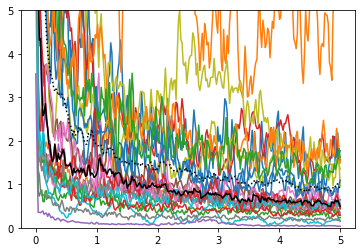

In [38]:
Specs[sub_evs].loc[:,r_parts].plot(legend=False)
Specs[sub_evs].loc[:,r_parts].median(axis=1).plot(c='k')
Specs[sub_evs].loc[:,r_parts].mean(axis=1).plot(c='k',linestyle=':')
plt.ylim([0,5])

In [39]:
ev = 'Folk 6'
r_parts = ['BEQ095', 'BEQ096', 'BEQ097', 'BEQ098', 'BEQ099', 'BEQ100', 'BEQ101',
       'BEQ102', 'BEQ103', 'BEQ105', 'BEQ106', 'BEQ107', 'BEQ108', 'BEQ109',
       'BEQ110', 'BEQ111', 'BEQ112', 'BEQ113', 'BnQ131', 'BnQ132', 'BnQ133']
# Specs[ev].loc[:,Specs[ev].columns.str.startswith('B')].columns

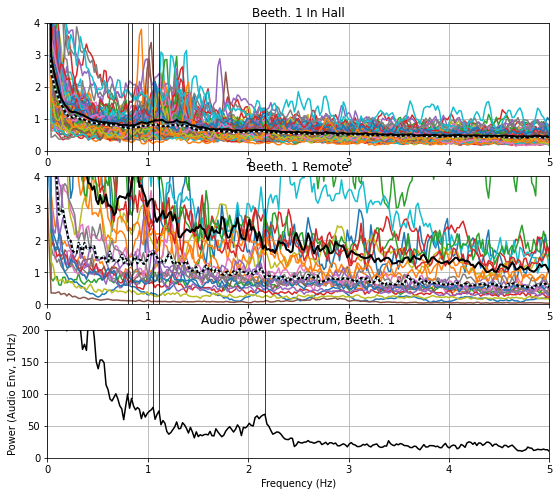

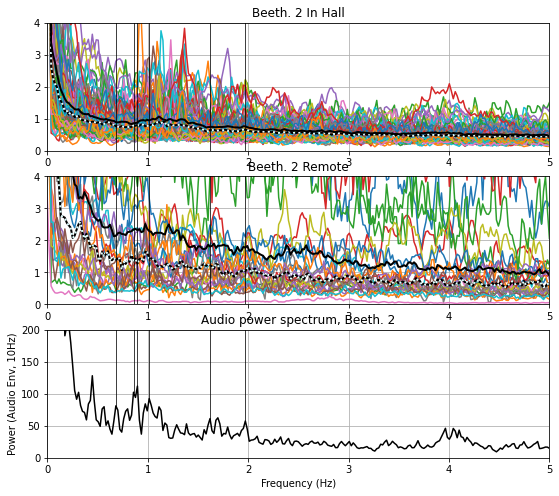

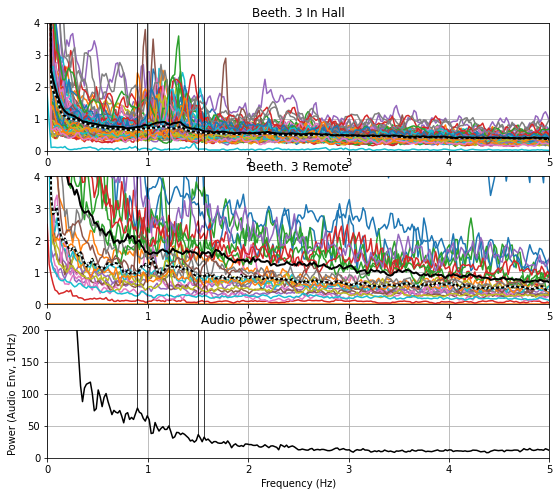

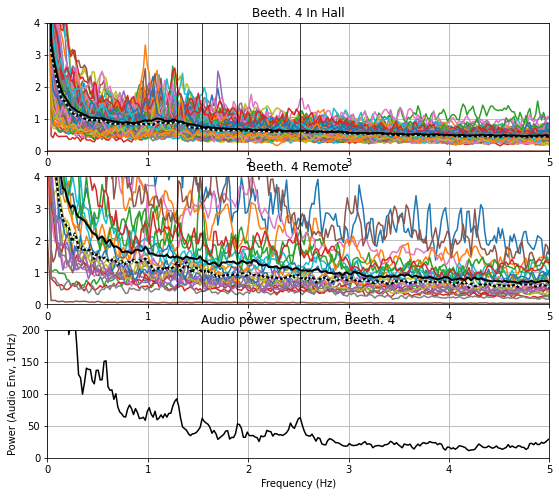

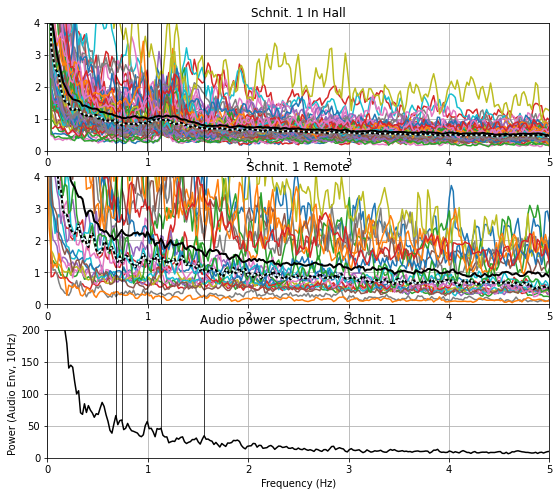

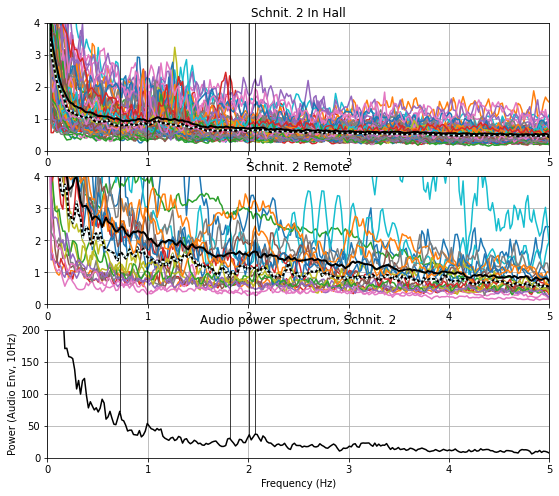

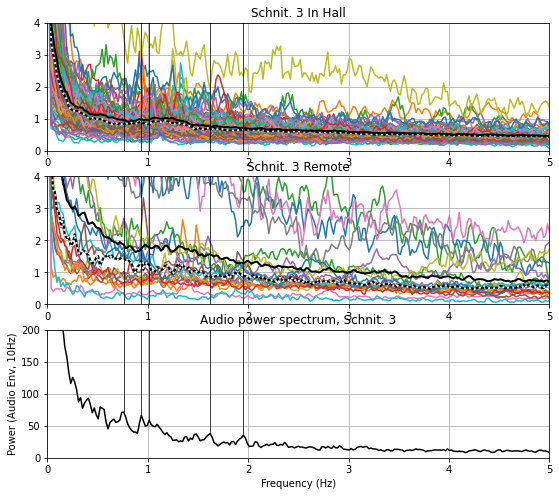

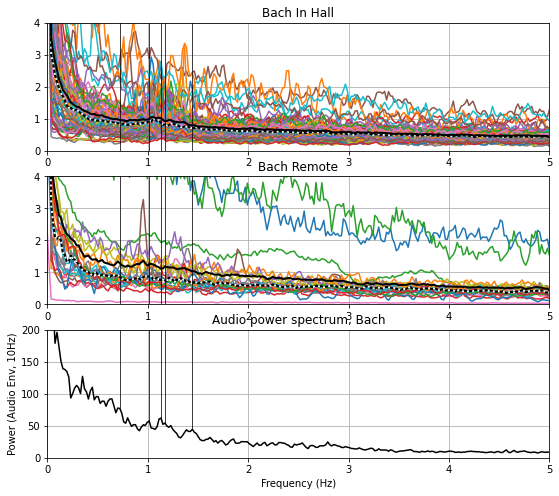

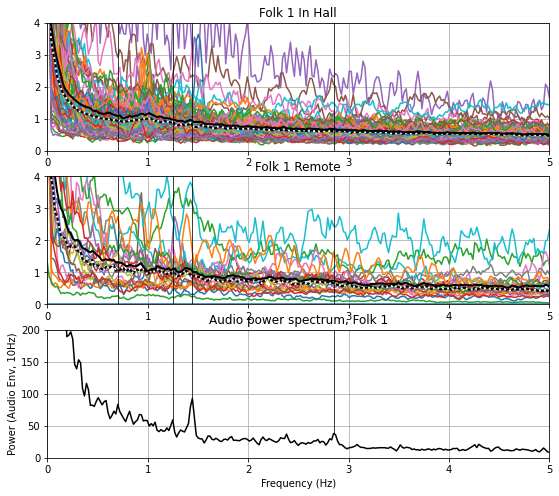

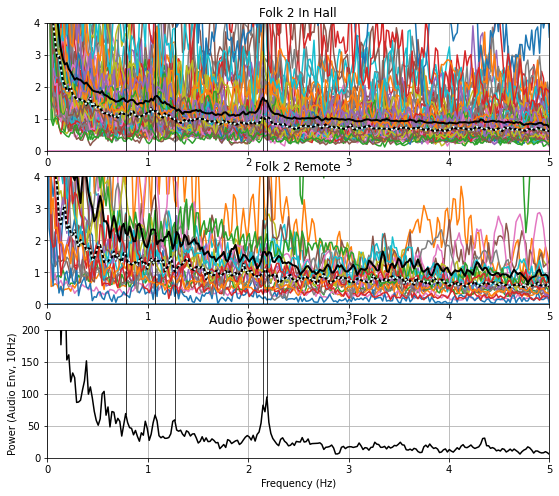

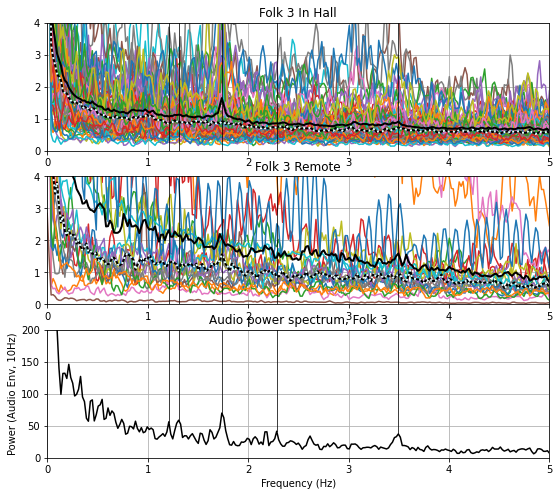

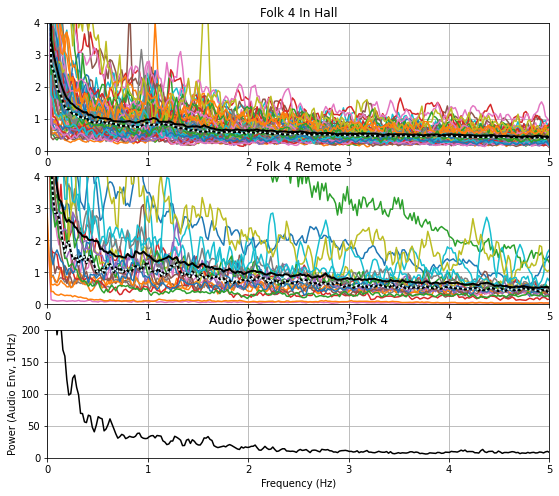

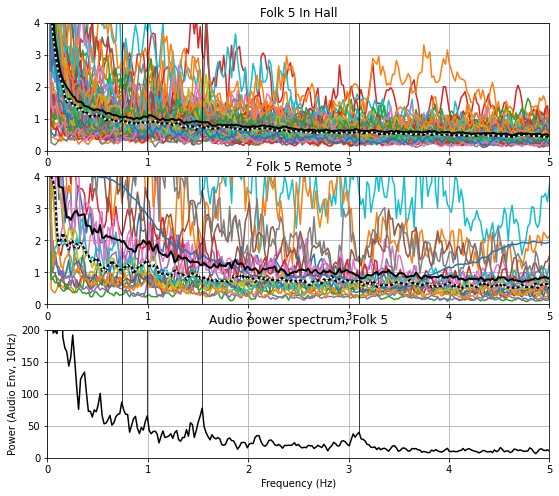

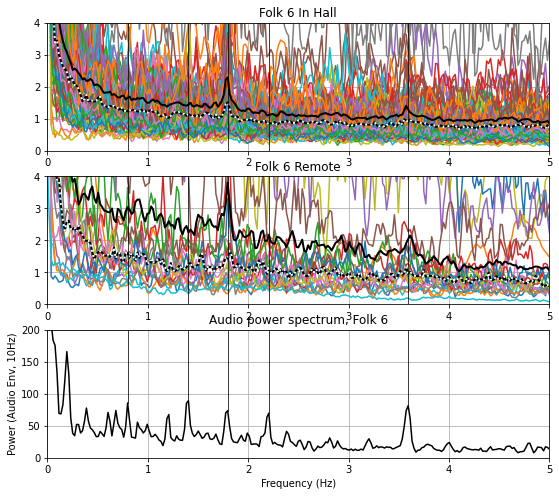

In [42]:
evs = ['Beethoven','Schnittke_Bach','Folk']
for i in range(len(evs)):
    ev = evs[i]
    sub_evs = MTs.query('Sections in @ev.split("_")')['Shorter_tag'].values
    for ev in sub_evs:
        fig, axes = plt.subplots(3,1,figsize=(9, 8))
        ax = axes[0]
        r_parts = Specs[ev].loc[:,Specs[ev].columns.str.startswith('A')].columns
        Specs[ev].loc[:,r_parts].plot(legend=False,ax=ax)
        Specs[ev].loc[:,r_parts].median(axis=1).plot(c='k',linewidth = 2, ax=ax)
        Specs[ev].loc[:,r_parts].median(axis=1).plot(c='lightcyan',linewidth = 2,linestyle=':',ax=ax)
        Specs[ev].loc[:,r_parts].mean(axis=1).plot(c='k',linewidth = 2, ax=ax)
        ax.grid()
        ax.set(xlim=(0,5),ylim=(0, 4))
        ax.set_title(ev + ' In Hall')
        
        ax = axes[1]
        r_parts = Specs[ev].loc[:,Specs[ev].columns.str.startswith('B')].columns
        Specs[ev].loc[:,r_parts].plot(legend=False,ax=ax)
        Specs[ev].loc[:,r_parts].median(axis=1).plot(c='k',linewidth = 2, ax=ax)
        Specs[ev].loc[:,r_parts].median(axis=1).plot(c='lightcyan',linewidth = 2,linestyle=':',ax=ax)
        Specs[ev].loc[:,r_parts].mean(axis=1).plot(c='k',linewidth = 2, ax=ax)
        ax.grid()
        ax.set(xlim=(0,5),ylim=(0, 4))
        ax.set_title(ev + ' Remote')       
        
        ax = axes[2]
        DAs_sub = DAs.query('Event in @ev')
        sns.lineplot(data=DAs_sub, x='Frequency',y='Power',c='k', errorbar=errorbarType,err_style='band',legend=False,ax=ax) #
        ax.set(xlim=(0,5),ylim=(0, 200))
        ax.grid()
        ax.set_xlabel('Frequency (Hz)')
        ax.set_ylabel('Power (Audio Env, 10Hz)')
        ax.set_title('Audio power spectrum, '+ ev)
        
        minf = 0.5
        a = DAs.query('Event==@ev').loc[:,['Frequency','Power']].groupby(by=['Frequency']).mean()
        b = a.loc[minf:]-a.loc[minf:].rolling(15,center=True).mean()
        thresh = b.quantile(0.97).values[0]
        b[b<thresh] = 0
        peaks = np.sign(b.diff()).diff().shift(-1).query('Power == -2.0')
        peaks['Power'] = a.loc[peaks.index]
        if b.loc[peaks.index].max().values[0]>10:  # previous b
            for j,peak in peaks.iterrows():
                axes[0].plot([j,j],[0,qom_ylim],linewidth = 1,color='k',alpha = 0.75)
                axes[1].plot([j,j],[0,qom_ylim],linewidth = 1,color='k',alpha = 0.75)
                axes[2].plot([j,j],[peak['Power'],200],linewidth = 1,color='k',alpha = 0.75) 
        
        plt.savefig('./supplemental_plots/QoMAudio_spectrum_'+ev+'_Hall_Remote.png', bbox_inches = 'tight',dpi = 196)#

        plt.show()

These plots compare, for each piece, the individual participant average power spectrum, mean and median for each audience (in hall and remote) and the audio energy envelope power spectrum (peaks picked). 

Comparing the average and median for each audience helps distinguish when peaks are outlier driven (more of a problem for remote audience with wider range of energy levels and fewer instances) and when a majority of the audience is sharing in the action. 

Neither audience looks to be expressing music periodicities for any of the classical pieces. Nothing comparable to the behaviour during some of the folk. 

For Folk 2, the in Hall audience shows a strong frequency peak match in the average and the median, while the remote audience does not show a similar movement peak.

For Folk 3, the in Hall average shows a music frequency peak while the median does not. So there is a minority of the audience moving to this pieces in the hall. Remotely, however, both the mean and median show peaks at beat and subdivision tempi. So this piece was more "popular" for motion for the audience watching at home. 

For Folk 6, the In Hall and Remote audiences both show matching music frequency peaks in their averages and medians. the main component in the same, while the in hall audience shows a strong subdivision bump (3.6 Hz ish) in both summary time series. 

Last note: the remote audience measurements do not show a heatbeat bump. This could be for many reasons. The first being phone placement: we can't assume they positioned their phones exactly the same way (6 cm below the suprasternal notch), and some might have used a pocket instead. The second being more motion over all, even during the Bach, the audience average power spectrum is higher than 1.0 at 1 Hz, higher than the in hall audience, thus obscuring such a small energy contribution. 